In [101]:
using Gen
using Random
using Plots
using Combinatorics

Defining a model

In [86]:
uniform_2D = ProductDistribution(uniform, uniform)
normal_2D = ProductDistribution(normal, normal)

function velocity_in_bounds(x, vx, heading, scene_size)
    if x + vx * heading < 0 || x + vx * heading > scene_size
        return -vx
    else
        return vx
    end
end

@gen function model(scene_size::Float64, steps::Int64, max_fireflies::Int64)
    """
    Runs a chain of fireflies for a given number of steps using a random walk
    Args:
        scene_size: Int:  the size of the scene
        steps: Int:  the number of steps to run the chain
        max_fireflies: Int:  the maximum number of fireflies
    Returns:
        xs: Array{Float64, 2}:  the x coordinates of the fireflies at each step
        ys: Array{Float64, 2}:  the y coordinates of the fireflies at each step
        blinks: Array{Int64, 2}:  the number of blinks of the fireflies at each step
    """
    n_fireflies ~ uniform_discrete(1, max_fireflies)
    blinks = zeros(Int64, n_fireflies, steps)
    locations = zeros(Float64, n_fireflies, steps, 2)
    velocities = zeros(Float64, n_fireflies, steps, 2)
    headings = zeros(Float64, n_fireflies, steps)
    
    for t in 1:steps
        for n in 1:n_fireflies
            if t == 1
                headings[n, t] = {(:heading, n, t)} ~ uniform(-pi, pi)
                locations[n, t, :] .= {(:loc, n, t)} ~ uniform_2D(1., scene_size, 1., scene_size)
                velocities[n, t, :] .= {(:vel, n, t)} ~ uniform_2D(-1., 1., -1., 1.)
            else
                prev_x, prev_y = locations[n, t-1, :]
                prev_vx, prev_vy = velocities[n, t-1, :]
                prev_heading = headings[n, t-1]
                prev_vx = velocity_in_bounds(prev_x, prev_vx, cos(prev_heading), scene_size)
                prev_vy = velocity_in_bounds(prev_y, prev_vy, sin(prev_heading), scene_size)
                
                new_x = prev_x + prev_vx * cos(prev_heading)
                new_y = prev_y + prev_vy * sin(prev_heading)
                locations[n, t, :] .= {(:loc, n, t)} ~ normal_2D(new_x, .1, new_y, .1)
                velocities[n, t, :] .= {(:vel, n, t)} ~ normal_2D(prev_vx, 0.1, prev_vy, 0.1)
                
                headings[n, t] = {(:heading, n, t)} ~ normal(prev_heading, 0.35)
            end
            blinks[n, t] = {(:blink, n, t)} ~ bernoulli(0.1)
        end
    end
    return locations, blinks
end

constraints = choicemap()
constraints[:n_fireflies] = 3
gt_tr, gt_w = generate(model, (32., 100, 4), constraints)
choices = get_choices(gt_tr);

## Visualizations

Let's visualize what the underlying observations look like, as well as the underlying motion model.

[ Info: Saved animation to /Users/yonifriedman/Research/ProbComp/Fireflies/fireflies.gif


Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/fireflies.gif")
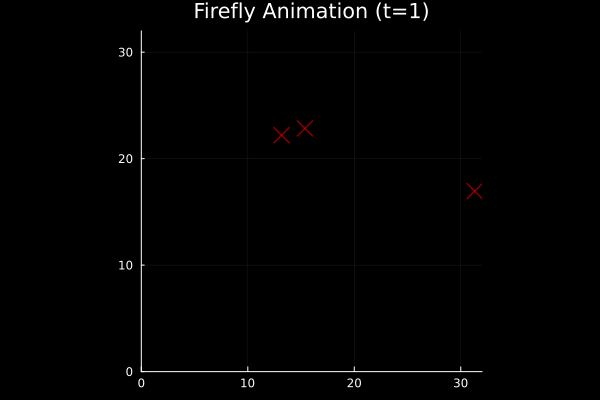

In [87]:
function animate_fireflies(xs, ys, blinking)
    # Input validation
    n_fireflies, timesteps = size(xs)
    @assert size(ys) == (n_fireflies, timesteps) "Position arrays must have same dimensions"
    @assert size(blinking) == (n_fireflies, timesteps) "Blinking array must match position arrays"
    
    # Create animation
    anim = @animate for t in 1:timesteps
        # Create empty plot with fixed bounds
        plot(
            xlim = (minimum(xs) - 0.1, maximum(xs) + 0.1),
            ylim = (minimum(ys) - 0.1, maximum(ys) + 0.1),
            legend = false,
            aspect_ratio = :equal,
            title = "Firefly Animation (t=$t)",
            background_color = :black
        )
        xlims!(0, 32)
        ylims!(0, 32)
        
        # Plot each firefly
        for i in 1:n_fireflies
            if blinking[i, t] == 1
                # Blinking firefly: yellow circle
                scatter!([xs[i, t]], [ys[i, t]], 
                    markershape = :circle,
                    markercolor = :yellow,
                    markersize = 8,
                    markerstrokewidth = 0)
            else
                # Non-blinking firefly: red x
                scatter!([xs[i, t]], [ys[i, t]], 
                    markershape = :x,
                    markercolor = :red,
                    markersize = 8,
                    markerstrokewidth = 2,
                    alpha = 0.5)
            end
        end
    end
    
    return gif(anim, "fireflies.gif", fps = 10)
end

locations, blinks = get_retval(gt_tr)
xs = locations[:, :, 1]
ys = locations[:, :, 2]
animate_fireflies(xs, ys, blinks)

In addition, we can visualize the sum of blinks over time, to make it easier to see what the inference problem is trying to solve.

Effectively, we want to infer correspondences between observed blinks, and the fireflies that caused them. This also requires us to 
guess the number of fireflies in the scene.

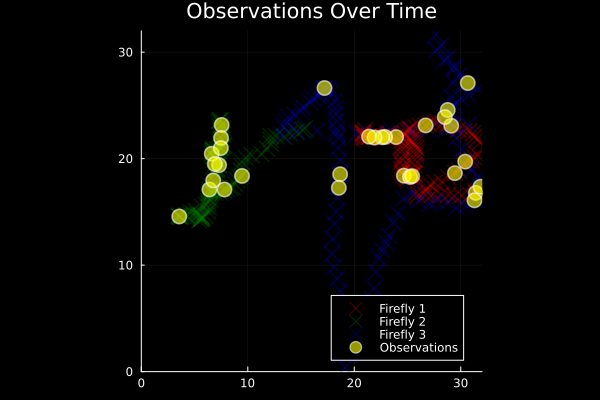

In [88]:
# Plot a single image with blinks across time
all_blink_xs = []
all_blink_ys = []
for t in 1:size(blinks, 2)
    for n in 1:size(blinks, 1)
        if blinks[n, t] == 1
            push!(all_blink_xs, xs[n, t])
            push!(all_blink_ys, ys[n, t])
        end
    end
end

fig = plot(
    xlim = (0, 32),
    ylim = (0, 32),
    legend = :bottomright,
    aspect_ratio = :equal,
    title = "Observations Over Time",
    background_color = :black
)

colors = [:red, :green, :blue, :purple]
for i in 1:size(xs, 1)
    scatter!(xs[i, :], ys[i, :], markershape = :x, markercolor = colors[i], markersize = 8, markerstrokewidth = 2, alpha = 0.25,
    label = "Firefly $i")
end

scatter!(all_blink_xs, all_blink_ys, markershape = :circle, markercolor = :yellow, markersize = 8, markerstrokewidth = 2, alpha = 0.6, label = "Observations")

Given the correct number of fireflies, we can Rao-Blackwellize our correspondence hypotheses and compute $P(x \vert o, Z)$, where $x$ is the locations of each firefly, $o$ our observations, and $Z$ the correspondences between fireflies and those observations. Since we're using a simple gaussian motion model, we can solve that using a closed form, analytical solution.


First, we need to shuffle the observations at each timestep. 

In [96]:
function correspondence_free_observations(trace)
    """
    Returns shuffled observations of fireflies at each timestep
    Args:
        choices: Dict:  the choices made by the model
    Returns:
        all_obs: Array{Array{Tuple{Float64, Float64}, 1}, 1}:  Per-timestep array with all (x, y) observations at that step
    """
    choices = get_choices(trace)
    locations, blinks = get_retval(trace)
    xs = locations[:, :, 1]
    ys = locations[:, :, 2]
    n_fireflies, steps = size(xs)
    all_obs = []
    for t in 1:steps
        obs_t = []
        for n in 1:n_fireflies
            if choices[(:blink, n, t)] == 1
                push!(obs_t, (xs[n, t], ys[n, t]))
            end
        end
        shuffle(obs_t) # Break correspondence
        push!(all_obs, obs_t)
    end
    return all_obs
end


correspondence_free_observations (generic function with 1 method)

Now, we can look at how different correspondences would score under our current motion model. 

At each timestep, there are $\binom{N}{K}$ ways of assigning $N$ observations to $K$ fireflies. Each assignment can be scored under a linear gaussian motion model (ignoring for now things like velocity or heading). 


In [106]:
function enumerate_correspondences(observations, K)
    """
    Enumerates all possible correspondences between observations and fireflies. We assume that each 
    observation corresponds to exactly one firefly.
    Args:
        observations: Array{Array{Tuple{Float64, Float64}, 1}, 1}:  Per-timestep array with all (x, y) observations at that step
        K: Int:  the number of fireflies
    Returns:
        all_correspondences: Array{Array{Int, 1}, 1}:  All possible correspondences between observations and fireflies
    """
    all_correspondences = []
    for obs in observations
        if length(obs) == 0
            continue
        end
        
        # Generate all possible correspondences between o observations and K fireflies
        possible_correspondences = collect(permutations(1:K, length(obs)))
        push!(all_correspondences, possible_correspondences)
    end
    return all_correspondences
end

enumerate_correspondences (generic function with 1 method)

In [108]:
enumerate_correspondences(correspondence_free_observations(gt_tr), 3)

29-element Vector{Any}:
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 ⋮
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1, 2], [1, 3], [2, 1], [2, 3], [3, 1], [3, 2]]
 [[1, 2], [1, 3], [2, 1], [2, 3], [3, 1], [3, 2]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]
 [[1], [2], [3]]

In [136]:
@gen function sample_correspondence(observations)
    """
    Given a set of observations with no clear correspondence, sample a choicemap for inference
    Args:
        observations: correspondence-free observations of (x, y) coordinates at each timestep
    Returns:
        constraints: Dict:  the choicemap for the model with naively sampled correspondences
    """
    constraints = choicemap()
    # Get minimum possible fireflies by finding the timestep with the most observations
    min_fireflies = maximum([length(obs_t) for obs_t in observations])
    n_fireflies = uniform_discrete(min_fireflies, 4)
    for (t, obs_t) in enumerate(observations)
        available_ids = 1:n_fireflies
        for (n, (x, y)) in enumerate(obs_t)
            # Sample ID for each observation, and remove it from the available IDs
            n_tilde = {(:firefly_id, n, t)} ~ categorical([1/length(available_ids) for _ in available_ids])
            available_ids = filter(x -> x != n_tilde, available_ids)
            # Update constraints
            constraints[(:x, n_tilde, t)] = x
            constraints[(:y, n_tilde, t)] = y
            constraints[(:blink, n_tilde, t)] = 1
        end
        # Set remaining fireflies to not blink
        for n in available_ids
            constraints[(:blink, n, t)] = 0
        end
    end
    return constraints
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##sample_correspondence#596", Bool[0], false)

In [137]:
observations = correspondence_free_observations(gt_tr)

model_args = (32, 20, 4)
num_samples = 1000
(traces, log_norm_weights, lml_est) = importance_sampling(model,
    model_args, choices, sample_correspondence, 
    (observations,), num_samples)

(Gen.DynamicDSLTrace[Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##model#568", Bool[0, 0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:x, 2, 10) => Gen.ChoiceOrCallRecord{Float64}(11.514705398660844, -0.2601344854621932, NaN, true), (:x, 1, 19) => Gen.ChoiceOrCallRecord{Float64}(18.33564403911712, -0.22846917420958102, NaN, true), (:blink, 2, 13) => Gen.ChoiceOrCallRecord{Bool}(false, -0.10536051565782628, NaN, true), (:y, 3, 6) => Gen.ChoiceOrCallRecord{Float64}(16.88728766145029, -0.22975569394784745, NaN, true), (:blink, 3, 10) => Gen.ChoiceOrCallRecord{Bool}(false, -0.10536051565782628, NaN, true), (:blink, 1, 11) => Gen.ChoiceOrCallRecord{Bool}(false, -0.10536051565782628, NaN, true), (:blink, 1, 5) => Gen.ChoiceOrCallRecord{Bool}(false, -0.10536051565782628, NaN, true), (:blink, 2, 17) =

In [139]:
average_fireflies = sum([get_choices(trace)[:n_fireflies] for trace in traces]) / num_samples
println("Average number of fireflies: $average_fireflies")

Average number of fireflies: 3.0


In [ ]:
fig = histogram([log_norm_weights for trace in traces], bins = 1:5, legend = false,
    xlabel = "Number of Fireflies", ylabel = "Frequency", title = "Number of Fireflies in Inferred Traces")